In [124]:
import pandas
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.datasets import make_blobs
from scipy import sparse
import numpy as np
import sys
import getopt
import csv
import matplotlib.pyplot as plt

#----------------------------------------------------------------
# Class for user movie ratings.
#----------------------------------------------------------------
class ratings():
    #------------------------------------------------------------------
    # Initialize our ratings. self.movies and self.ratings.
    #------------------------------------------------------------------
    def __init__(self, initialMoviesFile, initialRatingsFile):
        # These structures will probably be merged into a pandas 
        # dataFrame 
        # going to use a dict, with movie_id as the key, for movies because movie_id has a 1-to-1 relation with movie
        self.movies = {}  # {movie_id: {genre, title}}
        # a movie_id can have multiple ratings. going to use a dict of lists
        self.ratings_by_movie_id = {}  # {movie_id: [{user_id, rating}]}
        # a user_id can have multiple ratings. going to use a dict of lists
        self.ratings_by_user_id = {}  # {user_id: [{movie_id, rating}]}
        self.movies_by_genre = {} # {genre: [movie_id]}
        self.ratings_by_movie_id_for_sklearn = {}  # {movie_id: {user_id: rating}}
        self.parse_movies(initialMoviesFile)
        self.parse_ratings(initialRatingsFile)
        self.user_id=0
        self.login=False
    
    #------------------------------------------------------------------
    # login a user. 
    #------------------------------------------------------------------
    def loginUser(self,user_id):
        self.user_id=user_id
        for rating in self.ratings_by_user_id:
            if rating['user_id']==user_id:
                self.login=True
        return self.login
    
    ################# Accumulation methods ############################
    #------------------------------------------------------------------
    # Add a rating
    #------------------------------------------------------------------
    def addRating(self, user_id, movie_id, rating, timestamp):
        self.ratings_by_movie_id[movie_id].append({'user_id':user_id,'movie_id':movie_id,'rating':rating,'timestamp':timestamp})
        self.ratings_by_user_id[user_id].append({'user_id':user_id,'movie_id':movie_id,'rating':rating,'timestamp':timestamp})
    
    #------------------------------------------------------------------
    # Add a user. 
    #------------------------------------------------------------------
    def addUser(self):
        self.user_id=0
        for rating in self.ratings_by_user_id:
            if rating['user_id']>self.user_id:
                self.user_id=rating['user_id']+1
        return self.user_id
    
    #------------------------------------------------------------------
    # Parse the ratings file.
    #------------------------------------------------------------------
    def parse_ratings(self,ratingsFile):
        with open(ratingsFile) as csv_file:
            csv_r = csv.reader(csv_file, delimiter=",")
            line_count = 0
            for row in csv_r:
                line_count += 1
                if line_count > 1:
                    if not int(row[0]) in self.ratings_by_user_id:
                        self.ratings_by_user_id[int(row[0])] = []
                    self.ratings_by_user_id[int(row[0])].append({
                        "movie_id": int(row[1]),
                        "rating": float(row[2]),
                        "timestamp": int(row[3])
                    })
                    if not int(row[1]) in self.ratings_by_movie_id:
                        self.ratings_by_movie_id[int(row[1])] = []
                    self.ratings_by_movie_id[int(row[1])].append({
                        "user_id": int(row[0]),
                        "rating": float(row[2]),
                        "timestamp": int(row[3])
                    })
                    if not int(row[1]) in self.ratings_by_movie_id_for_sklearn:
                        self.ratings_by_movie_id_for_sklearn[int(row[1])] = {}
                    self.ratings_by_movie_id_for_sklearn[int(row[1])][int(row[0])] = float(row[2])
    
    #------------------------------------------------------------------
    # Parse the movies file.
    #------------------------------------------------------------------
    def parse_movies(self,moviesFile):
        with open(moviesFile) as csv_file:
            csv_r = csv.reader(csv_file, delimiter=",")
            line_count = 0
            for row in csv_r:
                line_count += 1
                if line_count > 1:
                    if row[2]:
                        genres = row[2].split("|")
                        for genre in genres:
                            if genre.lower() not in self.movies_by_genre:
                                self.movies_by_genre[genre.lower()] = []
                            self.movies_by_genre[genre.lower()].append(int(row[0]))
                    self.movies[int(row[0])] = {
                        "title": row[1],
                        "genres": genres
                    }
    
    ############# End Accumulation methods ############################
    
    ############# Clustering methods ##################################
    #------------------------------------------------------------------
    # Find similar movies for a user, based on a given movie. 
    #------------------------------------------------------------------
    #from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
    def similarMovie(self, movie_id, nMovies, T, N, I, method): 
        v=DictVectorizer(sparse=True)
        print(type(self.ratings_by_movie_id))
        R=[self.ratings_by_movie_id_for_sklearn[d] for d in self.ratings_by_movie_id_for_sklearn]
        X=v.fit_transform(R)
        print(X)
        if method==KMeans:
            clusterizer=method(n_clusters=N,tol=0.01,max_iter=200)
        if method==Birch:
            clusterizer=method(threshold=1,branching_factor=5,n_clusters=N)
        if method==AgglomerativeClustering:
            clusterizer=method(n_clusters=N,affinity='euclidean',linkage='ward')
        clustering=clusterizer.fit_predict(X)
        plt.figure(figsize=(100, 100))
        X_varied, y_varied = make_blobs(n_samples=len(self.ratings_by_movie_id),random_state=5893)
        plt.subplot()
        plt.scatter(X_varied[:, 0], X_varied[:, 1], c=clustering)
        plt.title("movie clusters")
        plt.show()
    
    #------------------------------------------------------------------
    # Find similar movies by genres.
    #------------------------------------------------------------------
    def similarGenres(self,user,genres):
        pass
    
    #------------------------------------------------------------------
    # Find a similar movies for a user, based on other users. 
    #------------------------------------------------------------------
    def similarUser(self, user):
        pass
        #sklearn.
  
    #------------------------------------------------------------------
    # Most popular movies by both rating and frequency. 
    #------------------------------------------------------------------
    def popularMovies(self):
        pass
    
    #------------------------------------------------------------------
    # Top Rated movies with highest rating. 
    #------------------------------------------------------------------
    def topRated(self):
        pass
    
    #------------------------------------------------------------------
    # Most frequently number of times rated regardless of ratings. 
    #------------------------------------------------------------------
    def frequentlyRatedRecently(self, timestamp):
        pass
    
    #------------------------------------------------------------------
    # Most number of times rated. 
    #------------------------------------------------------------------
    def frequentlyRated(self):
        pass
    
    ############# End Find/recommend methods ##########################
    
    ############## For testing and fine tuning ########################
    #------------------------------------------------------------------
    # Display graph.
    #------------------------------------------------------------------
    def displayGraph(self):
        pass
    
    ############## End of seperate class? #############################
    
    ############## Stand alone section ################################
    #------------------------------------------------------------------
    # Usage for running stand-alone testing
    #------------------------------------------------------------------
    def usage():
        print("Usage for ratings:")
        print("-h or --help")
        print("      Print this messege and quit")
        print("-m [filename] or --movies=[filename]")
        print("      Read movies from [filename]. Required!")
        print("-r [filename] or --ratings=[filename]")
        print("      Read ratings from [filename]. Required!")

movieFilename='comp-7118-project/movielens/movies.csv'
ratingFilename='comp-7118-project/movielens/ratings.csv'
#initialMovies=pandas.read_csv(movieFilename)
#initialRatings=pandas.read_csv(ratingFilename)
rData=ratings(movieFilename,ratingFilename)
v=DictVectorizer(sparse=True)
print(type(rData.ratings_by_movie_id))
R=[rData.ratings_by_movie_id_for_sklearn[d] for d in rData.ratings_by_movie_id_for_sklearn]
X=v.fit_transform(R)
print(type(X))
clusterizer=KMeans(n_clusters=40,max_iter=5000,n_jobs=4)
clustering=clusterizer.fit_predict(X)
print(len(clustering))

<class 'dict'>
<class 'scipy.sparse.csr.csr_matrix'>
3706


In [34]:
print('Obtaining 40 PCA components of movie ratings for visualization.')
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=40)
x=svd.fit_transform(X)
print(x)

[[ 1.10300404e+02  5.08337682e+01  9.85155226e-01 ... -1.47278332e+01
  -8.95523007e-01  1.82859539e+01]
 [ 3.39350462e+01 -2.56411329e+00  2.03075133e-01 ... -1.38851888e+00
  -3.98265064e-01  3.91291540e-01]
 [ 4.79138673e+01  2.47025886e+01  6.69577111e+00 ...  2.62609221e-01
   1.44773959e+00  2.61115607e+00]
 ...
 [ 1.32270570e-02 -2.55064270e-02 -1.36891046e-02 ...  1.90624800e-02
   2.99992128e-04  1.10073177e-03]
 [ 5.53597633e-02 -1.99948587e-02  8.00514548e-02 ... -1.16953813e-01
  -5.24727004e-02  3.11321953e-02]
 [ 4.74221121e-02  1.06645126e-02 -5.11390487e-02 ...  8.09922117e-02
   4.28932293e-02 -1.25936122e-02]]


In [144]:
print('Reducing dimension of PCA to 2 for t-distributed Stochastic Neighbor Embedding visualization.')
from sklearn.manifold import TSNE
#x = TSNE(n_components=3).fit_transform(X.toarray())
x_TSNE = TSNE(n_components=2, perplexity = 100, n_iter=10000).fit_transform(x)
print(x_TSNE)

[[-14.971812 -34.87358 ]
 [ 20.775488  27.138494]
 [-18.289188 -36.80894 ]
 ...
 [-27.416483  25.530964]
 [-24.888968  26.716671]
 [-30.652205  24.205328]]


In [145]:
print(rData.movies[1]['genres'])
genres={}
for i in rData.movies:
    for j in rData.movies[i]['genres']:
        genres[j]=0
genreI=0
for i in genres:
    genres[i]=genreI
    genreI=genreI+1
print(genres)
centers=np.array([[0.0,0.0]]*40)
nCenters=[0]*40
c=[0]*40
for i in range(0,len(clustering)):
    centers[clustering[i]]=x_TSNE[i]+centers[clustering[i]]
    nCenters[clustering[i]]=nCenters[clustering[i]]+1
    c[clustering[i]]=clustering[i]
for i in range(0,40):
    centers[i]=centers[i]/nCenters[i]
#print(centers)
print(centers[:,0])

['Animation', "Children's", 'Comedy']
{'Animation': 0, "Children's": 1, 'Comedy': 2, 'Adventure': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Sci-Fi': 11, 'Documentary': 12, 'War': 13, 'Musical': 14, 'Mystery': 15, 'Film-Noir': 16, 'Western': 17}
[-15.81104851  36.21749878   6.05728047   0.0975972  -10.07612133
  41.45478948  37.56196022  16.67022959 -18.32429492  22.69398789
  -7.95746309  40.26336098  24.59520833  29.56671861  13.51735449
  40.94483662 -16.23061244  42.7634697   34.54556656  38.20404138
  43.02129364  25.72680664  22.25216341  34.30276108  42.46624947
  17.08166618   9.76810932  35.27267429  37.19694368 -13.94237868
  23.62232688  39.37334824  24.43814087  19.54917417  13.37886987
   4.21937254  -1.25565128  41.94611263  20.35389519  23.77456347]


Movie clusters generated by K-Means match their respective PCA embedding within the 
t-distributed Stochastic Neighbor Embedding:


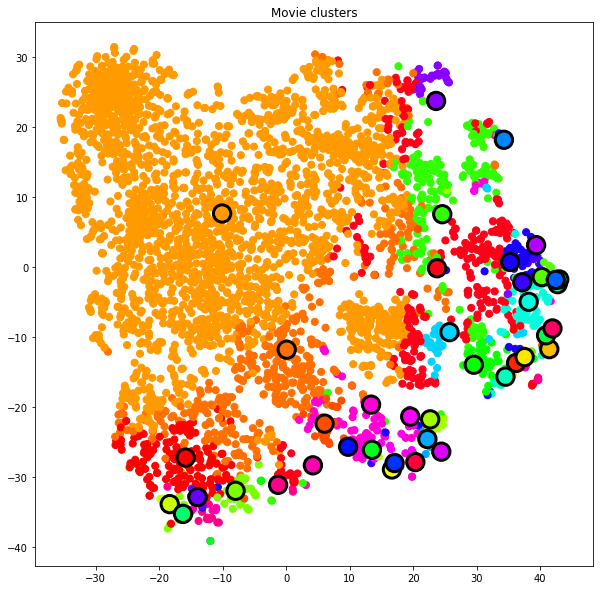

In [175]:
print('Movie clusters generated by K-Means match their respective PCA embedding within the ')
print('t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)

plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=clustering,s=50,cmap=plt.cm.hsv)
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,cmap=plt.cm.hsv,edgecolors='k',linewidths=3)

plt.title("Movie clusters")
plt.show()

In [174]:
print('A sample of the first 30 movies with their respective cluster:')
print('--------------------------------------------------------------')
pCount=0
table=[['Cluster','Movie Title']]
for i,j in zip(rData.ratings_by_movie_id,range(0,len(rData.movies))):
    if pCount<30:
        table.append([clustering[j],rData.movies[i]['title']])
        pCount=pCount+1
for i in table:
    print(i[0],'\t',i[1])


A sample of the first 30 movies with their respective cluster:
--------------------------------------------------------------
Cluster 	 Movie Title
35 	 One Flew Over the Cuckoo's Nest (1975)
30 	 James and the Giant Peach (1996)
10 	 My Fair Lady (1964)
23 	 Erin Brockovich (2000)
30 	 Bug's Life, A (1998)
18 	 Princess Bride, The (1987)
36 	 Ben-Hur (1959)
18 	 Christmas Story, A (1983)
30 	 Snow White and the Seven Dwarfs (1937)
16 	 Wizard of Oz, The (1939)
30 	 Beauty and the Beast (1991)
3 	 Gigi (1958)
0 	 Miracle on 34th Street (1947)
18 	 Ferris Bueller's Day Off (1986)
10 	 Sound of Music, The (1965)
18 	 Airplane! (1980)
30 	 Tarzan (1999)
30 	 Bambi (1942)
10 	 Awakenings (1990)
1 	 Big (1988)
9 	 Pleasantville (1998)
3 	 Wallace & Gromit: The Best of Aardman Animation (1996)
18 	 Back to the Future (1985)
7 	 Schindler's List (1993)
12 	 Meet Joe Black (1998)
30 	 Pocahontas (1995)
1 	 E.T. the Extra-Terrestrial (1982)
9 	 Titanic (1997)
4 	 Ponette (1996)
34 	 Close Shave

In [171]:
print('A sample of the first 30 movies in cluster 30:')
print('--------------------------------------------------------------')
pCount=0
table=[['Cluster','Movie Title']]
for i,j in zip(rData.ratings_by_movie_id,range(0,len(rData.movies))):
    if clustering[j]==30 and pCount<30:
        table.append([clustering[j],rData.movies[i]['title']])
for i in table:
    print(i[0],'\t',i[1])

A sample of the first 30 movies in cluster 30:
--------------------------------------------------------------
Cluster 	 Movie Title
30 	 James and the Giant Peach (1996)
30 	 Bug's Life, A (1998)
30 	 Snow White and the Seven Dwarfs (1937)
30 	 Beauty and the Beast (1991)
30 	 Tarzan (1999)
30 	 Bambi (1942)
30 	 Pocahontas (1995)
30 	 Antz (1998)
30 	 Hercules (1997)
30 	 Aladdin (1992)
30 	 Mulan (1998)
30 	 Hunchback of Notre Dame, The (1996)
30 	 Cinderella (1950)
30 	 Mary Poppins (1964)
30 	 Dumbo (1941)
30 	 Little Mermaid, The (1989)
30 	 Lion King, The (1994)
30 	 Charlotte's Web (1973)
30 	 Pinocchio (1940)
30 	 Jungle Book, The (1967)
30 	 Lady and the Tramp (1955)
30 	 Fantasia (1940)
30 	 Peter Pan (1953)
30 	 Robin Hood (1973)
30 	 NeverEnding Story, The (1984)
30 	 Sleeping Beauty (1959)
30 	 Sword in the Stone, The (1963)
30 	 Alice in Wonderland (1951)
30 	 Goonies, The (1985)
30 	 Prince of Egypt, The (1998)
30 	 Iron Giant, The (1999)
30 	 Secret of NIMH, The (1982)


In [ ]:
print('Displaying cluster 30 within the t-distributed Stochastic Neighbor Embedding:')
plt.figure(figsize=(10, 10))
plt.subplot(111)
clusterThirty=[0]
plt.scatter(x_TSNE[:,0], x_TSNE[:,1],  c=clustering,s=50,cmap=plt.cm.hsv)
plt.scatter(centers[:,0],centers[:,1], c=c,s=300,cmap=plt.cm.hsv,edgecolors='k',linewidths=3)

plt.title("Movie clusters")
plt.show()